# Solving Fractional Order Differential Lorenz Equation

In this notebook, we will solve the Fractional Order Differential Lorenz Equation using the Caputo formula.

## Introduction

The Lorenz system is a classical chaotic system described by a set of ordinary differential equations. We extend this concept by introducing fractional derivatives.

The Fractional Order Lorenz Equation is given by:

Here, $x$, $y$, and $z$ are the state variables, and ${\alpha}$ is the fractional order of the derivatives.

$$
D^\alpha_t x(t) = \sigma (y - x) \\
D^\alpha_t y(t) = x (\rho - z) - y \\
D^\alpha_t z(t) = xy - \beta z
$$

## Caputo Fractional Derivative

The Caputo definition for fractional derivative of order ${\alpha}$ for a function $f(t)$ is given by:

$$
D^\alpha_t f(t) = \frac{1}{\Gamma(n-\alpha)} \int_0^t (t-\tau)^{n-\alpha-1} f^{(n)}(\tau) d\tau
$$

where ${\Gamma}$ is the gamma function and ${n-1 < \alpha < n}$.
Now apply any integration method to integrate the derivative result from above

## Idea
1: Find the fractional derivatives at current point using the Caputo formula above

2: Use any integration method to integrate the fractional derivatives results

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.special import gamma
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
from scipy.integrate import quad

In [2]:
# Parameters
sigma = 10.0
beta = 8.0/3
rho = 28.0
alpha = 0.9  
    
max_time = 4.0
t = np.linspace(0, max_time, int(250*max_time)) 
# Choose random starting points, uniformly distributed from -15 to 15
np.random.seed(1)
x0 = -15 + 30 * np.random.random((10, 3))

In [3]:
def drawer(x_t, N=10, angle=-30.0):
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')

    # prepare the axes limits
    ax.set_xlim((30, -30))
    ax.set_ylim((40, -40))
    ax.set_zlim((0, 60))
    
    
    # choose a different color for each trajectory
    colors = plt.cm.viridis(np.linspace(0, 1, N))

    for i in range(N):
        x, y, z = x_t[i,:,:].T
        lines = ax.plot(x, y, z, '-', c=colors[i])
        plt.setp(lines, linewidth=2)

    ax.view_init(30, angle)
    plt.show()

In [4]:
def solve_lorenz(N=10, max_time=4.0, sigma=sigma, beta=beta, rho=rho): 
    
    def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho): 
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z] 
    
    t = np.linspace(0, max_time, int(250*max_time)) 
    x_t = np.asarray([odeint(lorenz_deriv, x0i, t)
                      for x0i in x0])

    return t, x_t

## Caputo Fractional Derivative

The Caputo fractional derivative of order ${\alpha}$ for a function $f(t)$ is given by:

$$
D^\alpha_t f(t) = \frac{1}{\Gamma(n-\alpha)} \int_0^t (t-\tau)^{n-\alpha-1} f^{(n)}(\tau) d\tau
$$

In [5]:
def solver_fractional_order_lorenz(alpha, sigma=10.0, beta=8.0/3, rho=28.0):

    def fractional_integral(f, alpha, t):
        n = int(np.ceil(alpha))
        def ff(tau):
            dif = np.diff(np.gradient(f(tau)), n)
            length = len(dif)
            mul = ((t - tau) ** (n - alpha - 1)) * f(tau)
            if length > 0:
                return mul * dif[-1]
            else:
                return mul
        integrand = lambda tau: ff(tau)
        result, _ = quad(integrand, 0, t)
        return result / np.math.gamma(n - alpha)

    # Define the Lorenz equations as integral equations with fractional order
    def lorenz_integral_equations(xyz, t, sigma, rho, beta, alpha):
        x, y, z = xyz

        dx_dt = fractional_integral(lambda tau: (sigma * (y - x)), alpha, t)
        dy_dt = fractional_integral(lambda tau: ((x * (rho - z)) - y), alpha, t)
        dz_dt = fractional_integral(lambda tau: ((x * y) - (beta * z)), alpha, t)

        return [dx_dt, dy_dt, dz_dt]

    t_span = np.linspace(0, 4.0, 1000)
    x_t = []
    for x0i in x0:
        xti = odeint(lorenz_integral_equations, x0i, t_span[1:], args=(sigma, rho, beta, alpha))
        x_ti = [x0i]
        for xi in xti:
            x_ti.append(xi)
        x_t.append(x_ti)
        
    return np.array(x_t)

## Lorenz DE with integer order 1 solution

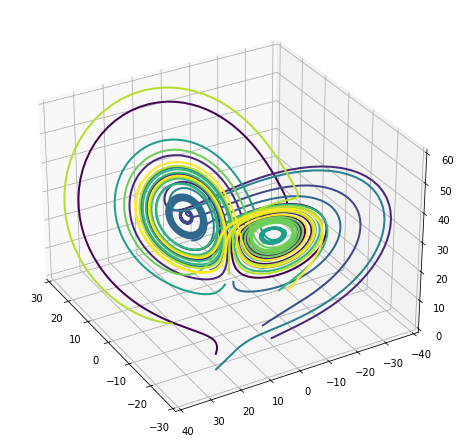

In [6]:
t, x_t = solve_lorenz()
drawer(x_t)

## Lorenz DE with Fractional order 0.993 solution

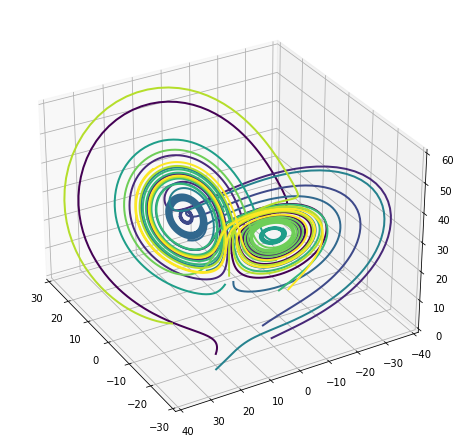

In [7]:
xd = solver_fractional_order_lorenz(0.993)
drawer(xd)

## Lorenz DE with Fractional order 0.4 solution

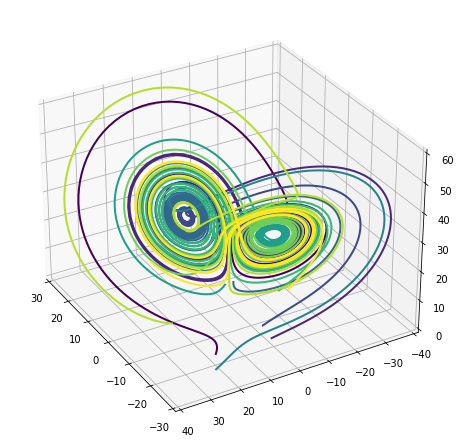

In [8]:
xd4 = solver_fractional_order_lorenz(0.4)
drawer(xd4)

## TRAINING AND MODELLING INTEGER 1 ORDER AND FRACTIONAL ORDER 0.993 LORENZ SYSTEM

In [8]:
from pyrcn.echo_state_network import ESNRegressor

In [9]:
def window_data(o_data, window_size):
    num_seq, seq_len, num_features = o_data.shape

    res = np.zeros((num_seq * (seq_len - window_size + 1), window_size, num_features))

    for i in range(num_seq):
        for j in range(seq_len - window_size + 1):
          start = i * (seq_len - window_size + 1) + j
          end = start + window_size
          res[start:end, :, :] = o_data[i, j:j+window_size, :]

    return res

In [10]:
def draw_attractor(data, title):

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    
    ax.set_xlim((-20, 30))
    ax.set_ylim((-20, 50))
    ax.set_zlim((5, 60))
    
    x, y, z = data[:,:].T
    ax.plot(x, y, z, '-')
    ax.view_init(25, -60)
    plt.title(title)
    plt.show()

## USING RCN ON LORENZ SYSTEM
Let's use Reservoir Computing Network on Lorenz system

In [11]:
def rcn_LORENZ_MODELLING(x_t):
    train_data = x_t[:7, :, :]
    test_data = x_t[7:, :, :]

    train = window_data(train_data, 11)
    test = window_data(test_data, 11)

    x_train = train[:, :10, :]
    y_train = train[:, -1, :]
    x_test = test[:, :10, :]
    y_test = test[:, -1, :]
    
    new_x_train = x_train.reshape(6930, 30)
    new_x_test = x_test.reshape(2970, 30)
    new_x_train.shape, new_x_test.shape
    
    lorenz_esn = ESNRegressor(
        bias_scaling=0, input_scaling=0.003126356923072247, 
        leakage=0.8, spectral_radius=0.6061121710836496
    )
    lorenz_esn.fit(new_x_train, y_train)
    y_pred = lorenz_esn.predict(new_x_test)
    
    return y_test, y_pred

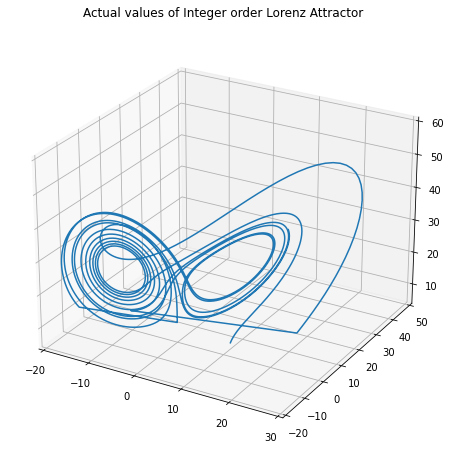

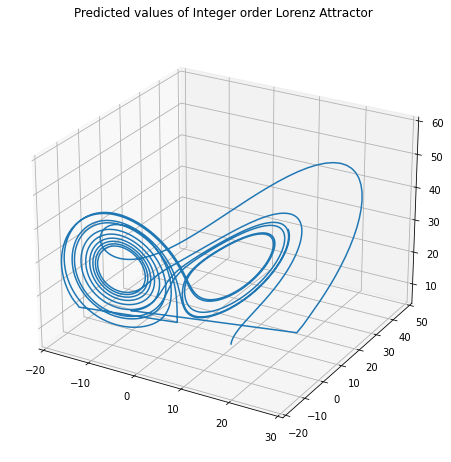

In [12]:
integer_order_lorenz_Actual, integer_order_lorenz_Pred = rcn_LORENZ_MODELLING(x_t) 

# print('Actual values of Integer order Lorenz Attractor')
draw_attractor(integer_order_lorenz_Actual, 'Actual values of Integer order Lorenz Attractor')  

# print('Predicted values of Integer order Lorenz Attractor')
draw_attractor(integer_order_lorenz_Pred, 'Predicted values of Integer order Lorenz Attractor')

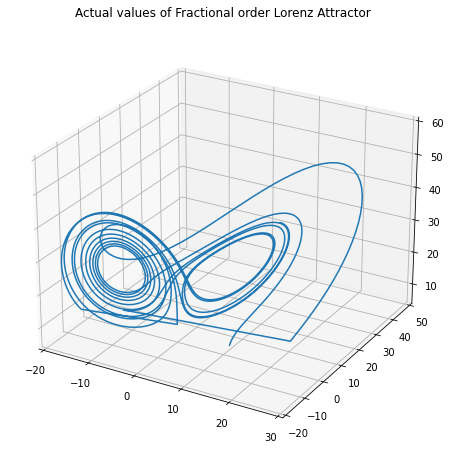

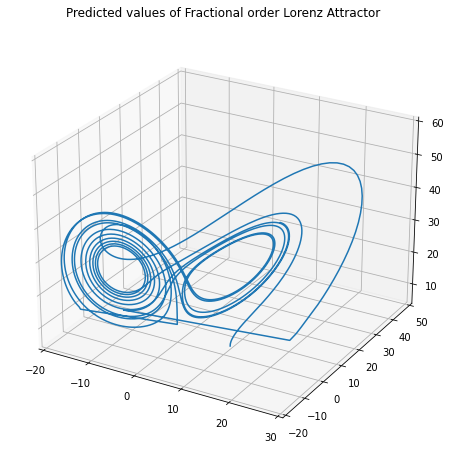

In [13]:
fractional_order_lorenz_Actual, fractional_order_lorenz_Pred = rcn_LORENZ_MODELLING(xd) 

# print('Actual values of Fractional order Lorenz Attractor')
draw_attractor(fractional_order_lorenz_Actual, 'Actual values of Fractional order Lorenz Attractor')  

# print('Predicted values of Fractional order Lorenz Attractor')
draw_attractor(fractional_order_lorenz_Pred, 'Predicted values of Fractional order Lorenz Attractor')

In [14]:
def plot_diff(actual_val, pred_val, order):
    length = len(actual_val)
    tt = [i+1 for i in range(length)]
    
    actual_x = [actual_val[i][0] for i in range(length)]
    actual_y = [actual_val[i][1] for i in range(length)]
    actual_z = [actual_val[i][2] for i in range(length)]
    
    pred_x = [pred_val[i][0] for i in range(length)]
    pred_y = [pred_val[i][1] for i in range(length)]
    pred_z = [pred_val[i][2] for i in range(length)]
    
    colors = ['blue', 'red']
    
    
    def plot_show(actual, pred, val, color_vals):

        fig = plt
        fig.figure(figsize=(10, 6))
        fig.plot(tt, actual, label='Actual '+order+' order Lorenz '+val+' values', color=color_vals[0])
        fig.plot(tt, pred, label='Predicted '+order+' order Lorenz '+val+' values', color=color_vals[1], linestyle='--')

        fig.xlabel('Time')
        fig.ylabel(val+'Values')
        fig.title('Actual vs. Predicted '+order+' order Lorenz '+val+' values')
        fig.legend()
    
        fig.show()
        
        
        
    plot_show(actual_x, pred_x, 'X', colors)
    plot_show(actual_y, pred_y, 'Y', colors)
    plot_show(actual_z, pred_z, 'Z', colors)
        
    

## Actual vs. Predicted Integer 1 order Lorenz values

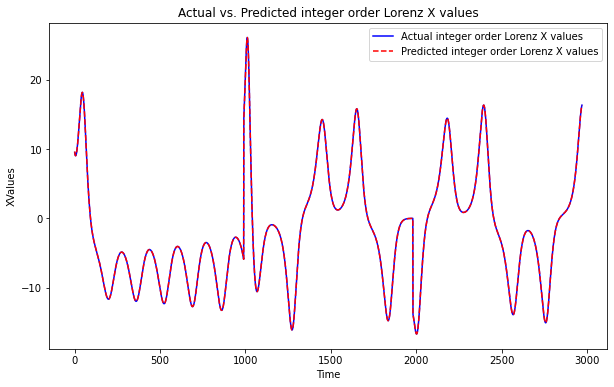

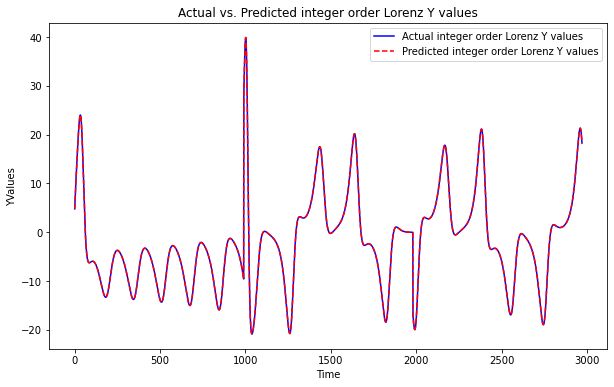

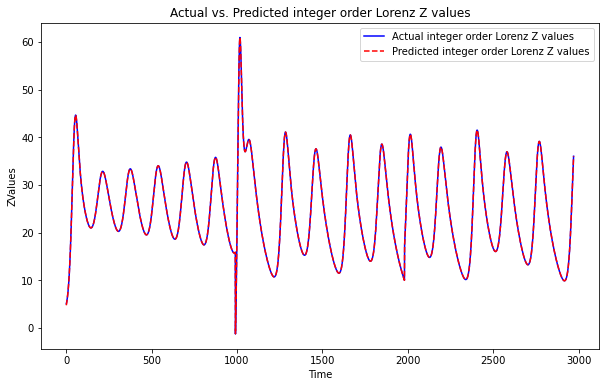

In [15]:
plot_diff(integer_order_lorenz_Actual, integer_order_lorenz_Pred, 'integer')

## Actual vs. Predicted Fractional order 0.993 Lorenz values

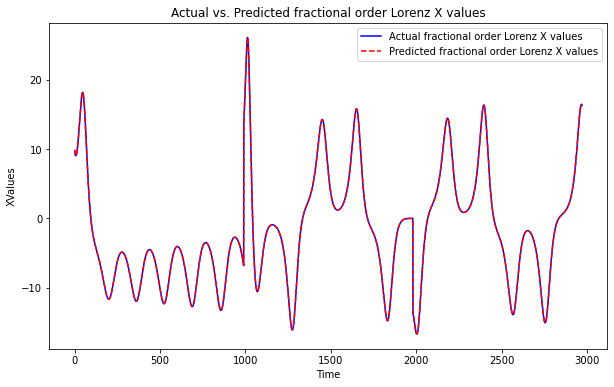

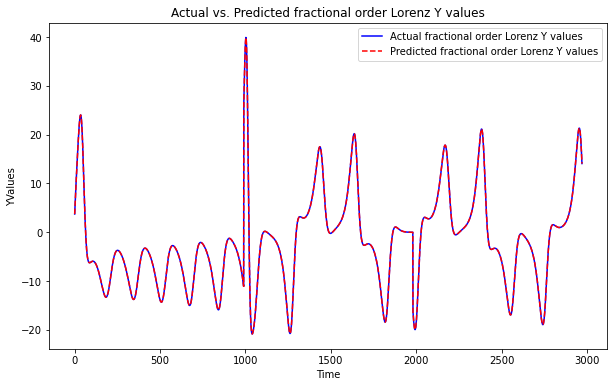

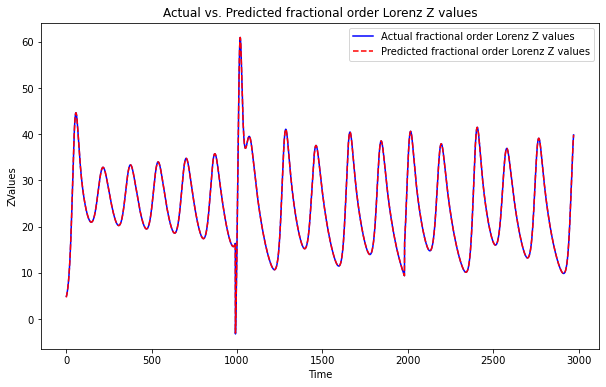

In [16]:
plot_diff(fractional_order_lorenz_Actual, fractional_order_lorenz_Pred, 'fractional')

In [17]:
def diff(int_val, fract_val, order):
    length = len(int_val)
    tt = [i+1 for i in range(length)]
    
    int_x = [int_val[i][0] for i in range(length)]
    int_y = [int_val[i][1] for i in range(length)]
    int_z = [int_val[i][2] for i in range(length)]
    
    fract_x = [fract_val[i][0] for i in range(length)]
    fract_y = [fract_val[i][1] for i in range(length)]
    fract_z = [fract_val[i][2] for i in range(length)]
    
    x = [abs(int_x[i] - fract_x[i]) for i in range(length)]
    y = [abs(int_y[i] - fract_y[i]) for i in range(length)]
    z = [abs(int_z[i] - fract_z[i]) for i in range(length)]
    
    colors = ['blue', 'red']
    
    
    def plot_show_t():

        fig = plt
        fig.figure(figsize=(10, 6))
        fig.plot(tt, x, label='Difference X', color=colors[0])
        fig.plot(tt, y, label='Difference Y', color=colors[1])
        fig.plot(tt, z, label='Difference Z', color='brown')

        fig.xlabel('Time')
        fig.ylabel('Differences')
        fig.title('Values differences')
        fig.legend()
    
        fig.show()
        
        
        
    plot_show_t()

## Checking That Fractional Order Solution is not same as Integer order 1 solution

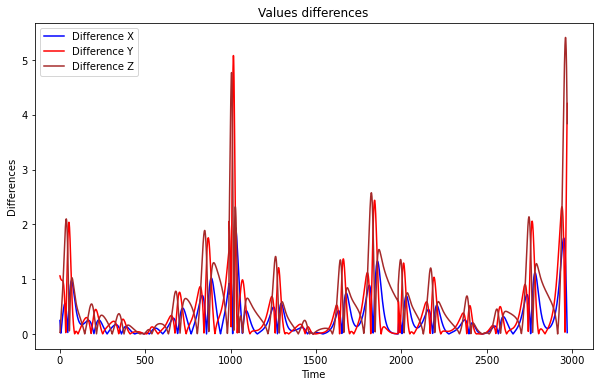

In [18]:
diff(integer_order_lorenz_Pred, fractional_order_lorenz_Pred, 'fractional')

## USING LSTM MODEL ON LORENZ SYSTEM
In the above we used Reservoir Computing Network (RCN)

Now let's use LSTM model

In [19]:
import tensorflow as tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [20]:
def lstm_LORENZ_MODELLING(x_t):
    train_data = x_t[:7, :, :]
    test_data = x_t[7:, :, :]

    train = window_data(train_data, 11)
    test = window_data(test_data, 11)

    x_train = train[:, :10, :]
    y_train = train[:, -1, :]
    x_test = test[:, :10, :]
    y_test = test[:, -1, :]
    
    model = Sequential()
    model.add(LSTM(36, input_shape=(None, 3)))
    model.add(Dense(3))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=2,epochs=50)
    y_pred = model.predict(x_test)
    
    return y_test, y_pred

In [21]:
integer_order_lorenz_lstm_Actual, integer_order_lorenz_lstm_Pred = lstm_LORENZ_MODELLING(x_t)

Epoch 1/50
217/217 - 20s - loss: 188.7696 - val_loss: 104.3939 - 20s/epoch - 91ms/step
Epoch 2/50
217/217 - 5s - loss: 75.8799 - val_loss: 55.0266 - 5s/epoch - 22ms/step
Epoch 3/50
217/217 - 5s - loss: 41.2021 - val_loss: 33.3021 - 5s/epoch - 22ms/step
Epoch 4/50
217/217 - 4s - loss: 25.2235 - val_loss: 21.9937 - 4s/epoch - 18ms/step
Epoch 5/50
217/217 - 5s - loss: 17.2669 - val_loss: 15.7348 - 5s/epoch - 21ms/step
Epoch 6/50
217/217 - 7s - loss: 12.8865 - val_loss: 11.8657 - 7s/epoch - 32ms/step
Epoch 7/50
217/217 - 6s - loss: 10.1088 - val_loss: 9.1238 - 6s/epoch - 26ms/step
Epoch 8/50
217/217 - 6s - loss: 8.1516 - val_loss: 7.2718 - 6s/epoch - 26ms/step
Epoch 9/50
217/217 - 4s - loss: 6.6640 - val_loss: 6.0633 - 4s/epoch - 20ms/step
Epoch 10/50
217/217 - 4s - loss: 5.4871 - val_loss: 4.9568 - 4s/epoch - 18ms/step
Epoch 11/50
217/217 - 4s - loss: 4.5586 - val_loss: 4.1734 - 4s/epoch - 20ms/step
Epoch 12/50
217/217 - 5s - loss: 3.8249 - val_loss: 3.5745 - 5s/epoch - 21ms/step
Epoch 13

In [22]:
fract_order_lorenz_lstm_Actual, fract_order_lorenz_lstm_Pred = lstm_LORENZ_MODELLING(xd)

Epoch 1/50
217/217 - 14s - loss: 201.1491 - val_loss: 117.0570 - 14s/epoch - 66ms/step
Epoch 2/50
217/217 - 5s - loss: 85.9252 - val_loss: 61.2089 - 5s/epoch - 22ms/step
Epoch 3/50
217/217 - 5s - loss: 44.2846 - val_loss: 35.1446 - 5s/epoch - 21ms/step
Epoch 4/50
217/217 - 4s - loss: 26.3372 - val_loss: 22.8451 - 4s/epoch - 20ms/step
Epoch 5/50
217/217 - 6s - loss: 17.8219 - val_loss: 16.1192 - 6s/epoch - 26ms/step
Epoch 6/50
217/217 - 6s - loss: 13.1728 - val_loss: 11.9807 - 6s/epoch - 28ms/step
Epoch 7/50
217/217 - 6s - loss: 10.1853 - val_loss: 9.1619 - 6s/epoch - 30ms/step
Epoch 8/50
217/217 - 4s - loss: 8.1034 - val_loss: 7.1459 - 4s/epoch - 18ms/step
Epoch 9/50
217/217 - 5s - loss: 6.5546 - val_loss: 5.7268 - 5s/epoch - 21ms/step
Epoch 10/50
217/217 - 4s - loss: 5.3682 - val_loss: 4.6647 - 4s/epoch - 19ms/step
Epoch 11/50
217/217 - 4s - loss: 4.4480 - val_loss: 3.9537 - 4s/epoch - 19ms/step
Epoch 12/50
217/217 - 4s - loss: 3.7206 - val_loss: 3.3862 - 4s/epoch - 18ms/step
Epoch 13

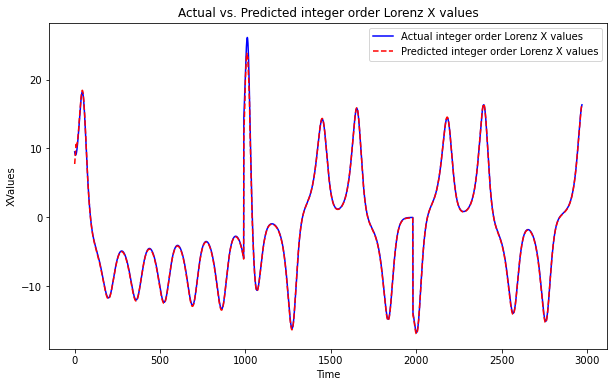

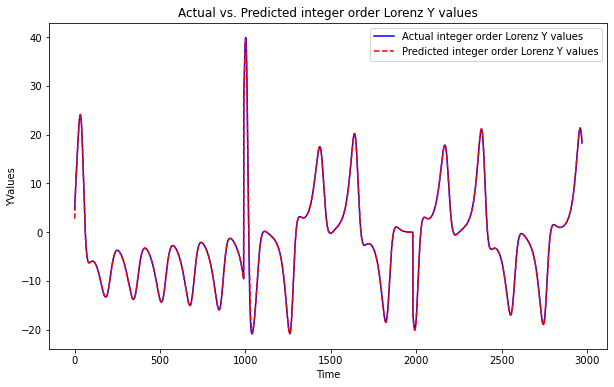

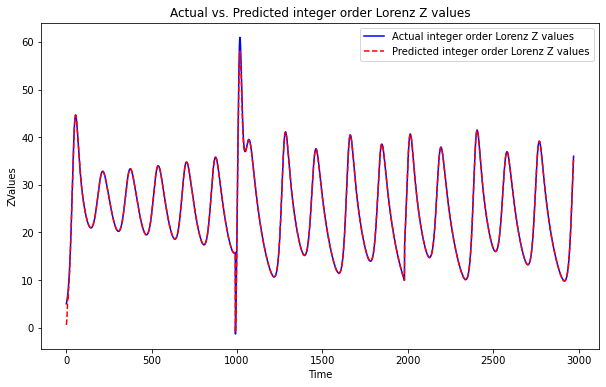

In [23]:
plot_diff(integer_order_lorenz_lstm_Actual, integer_order_lorenz_lstm_Pred, 'integer')

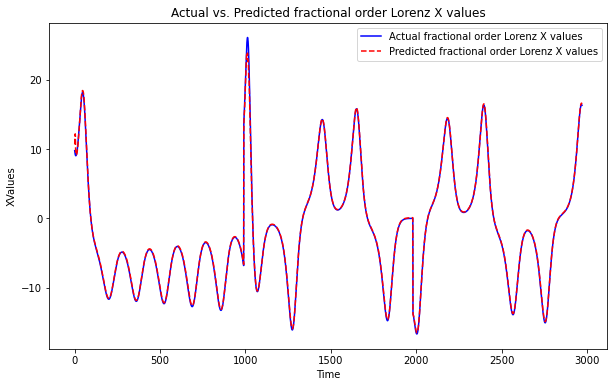

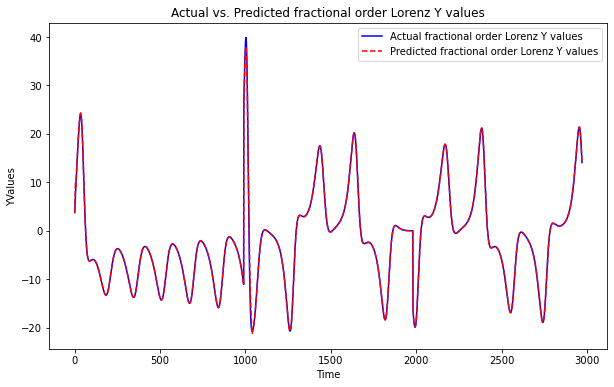

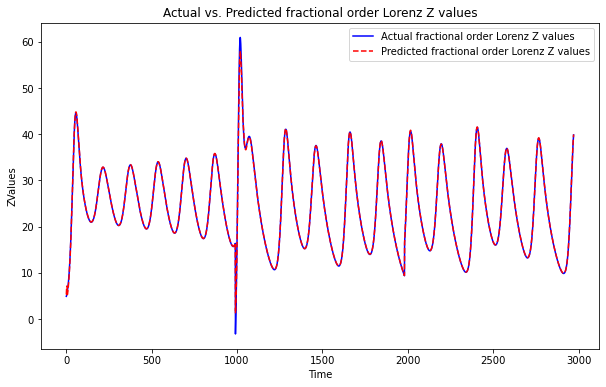

In [24]:
plot_diff(fract_order_lorenz_lstm_Actual, fract_order_lorenz_lstm_Pred, 'fractional')